# Project 2C

## Import thu vien

In [ ]:
import re
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import nltk
import numpy as np
from bertopic import BERTopic
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore,Nmf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from top2vec import Top2Vec

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## read data jsonl and metadata

In [ ]:
readme = pd.read_json("D:/social_network/crawl_readme/readme_data.jsonl", lines=True)
metadata = pd.read_csv(r"D:/social_network/crawl_readme/github_repos.csv")

In [ ]:
readme_c= readme.copy()

In [ ]:
readme_c.info()
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57383 entries, 0 to 57382
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   repo_id    57383 non-null  object        
 1   full_name  57383 non-null  object        
 2   readme     57383 non-null  object        
 3   timestamp  57383 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57383 entries, 0 to 57382
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   repo_id      57383 non-null  object
 1   name         57382 non-null  object
 2   full_name    57383 non-null  object
 3   description  56274 non-null  object
 4   topics       57383 non-null  object
 5   language     52730 non-null  object
 6   stars_count  57383 non-null  int64 
 7   forks_count  57383 non-null  int64 
 8   created_at   57383 non-null

### merge columns

In [ ]:
metadata = metadata[['repo_id', 'description',  'topics', 'language', 'stars_count', 'created_at', 'updated_at' ]]

In [ ]:
final_dataset = pd.merge(readme_c,metadata,on='repo_id')

In [ ]:
final_dataset = final_dataset[['repo_id','readme','description', 'topics', 'language', 'stars_count', 'created_at', 'updated_at']]

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57413 entries, 0 to 57412
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   repo_id      57413 non-null  object
 1   readme       57413 non-null  object
 2   description  56302 non-null  object
 3   topics       57413 non-null  object
 4   language     52756 non-null  object
 5   stars_count  57413 non-null  int64 
 6   created_at   57413 non-null  object
 7   updated_at   57413 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.5+ MB


### drop duplicated

In [ ]:
final_dataset.duplicated().sum()

44

In [ ]:
final_dataset.drop_duplicates(subset=['repo_id'],inplace=True)
final_dataset.reset_index(drop=True)

repo_id  \
0      MDEwOlJlcG9zaXRvcnkxNTUyMjA2NDE=   
1      MDEwOlJlcG9zaXRvcnk2NTYwMDk3NQ==   
2                          R_kgDOJ-2MVA   
3      MDEwOlJlcG9zaXRvcnk3MTU4MzYwMg==   
4      MDEwOlJlcG9zaXRvcnkxMTU0Nzg4MjA=   
...                                 ...   
57363                      R_kgDOHwL4GA   
57364  MDEwOlJlcG9zaXRvcnkxNjM1OTEyODk=   
57365  MDEwOlJlcG9zaXRvcnkxOTQ3OTYxNzM=   
57366  MDEwOlJlcG9zaXRvcnkxNzMyNTMyNzE=   
57367  MDEwOlJlcG9zaXRvcnkzMTU1NDc2NQ==   

                                                  readme  \
0      <!---\nCopyright 2020 The HuggingFace Team. Al...   
1      ![PyTorch Logo](https://github.com/pytorch/pyt...   
2      # Build a Large Language Model (From Scratch)\...   
3      <!-- omit in toc -->\n# Computer Science cours...   
4      [![Logo](/logo.png)](http://awesome-scalabilit...   
...                                                  ...   
57363  # Monitoring ML\n\nLearn how to monitor ML sys...   
57364  # CheckInstalledWindowsUpdates\nScript intende...   
57365  <p align="center"><a href="https://github.com/...   
57366  # ![](https://github.com/sourceplusplus/source...   
57367  # es-stats\n\nReads key cluster metrics from E...   

                                             description  \
0      🤗 Transformers: the model-definition framework...   
1      Tensors and Dynamic neural networks in Python ...   
2      Implement a ChatGPT-like LLM in PyTorch from s...   
3      List of Computer Science courses with video le...   
4      The Patterns of Scalable, Reliable, and Perfor...   
...                                                  ...   
57363  Learn how to monitor ML systems to identify an...   
57364  Script intended for use in an already establis...   
57365                      Easy to use monitoring system   
57366  The continuous feedback plugin for JetBrains IDEs   
57367          ElasticSearch cluster metrics -> Graphite   

                                                  topics          language  \
0      nlp;natural-language-processing;pytorch;pytorc...            Python   
1      neural-network;autograd;gpu;numpy;deep-learnin...            Python   
2      chatgpt;gpt;large-language-models;llm;python;p...  Jupyter Notebook   
3      computer-science;algorithms;systems;databases;...               NaN   
4      system-design;backend;scalability;interview;ar...               NaN   
...                                                  ...               ...   
57363  drift-detection;machine-learning;mlops;monitoring  Jupyter Notebook   
57364  windows;windows-10;windows-updates;windows-upd...        PowerShell   
57365       monitoring;network-monitoring;snmp;icmp-ping        JavaScript   
57366  jetbrains-plugin;feedback-driven-development;o...            Kotlin   
57367          elasticsearch;metrics;graphite;monitoring                Go   

       stars_count            created_at            updated_at  
0           150534  2018-10-29T13:56:00Z  2025-10-02T00:56:24Z  
1            93647  2016-08-13T05:26:41Z  2025-10-02T00:44:52Z  
2            74122  2023-07-23T18:15:57Z  2025-10-02T00:31:46Z  
3            69951  2016-10-21T17:02:11Z  2025-10-02T00:24:00Z  
4            65703  2017-12-27T03:46:40Z  2025-10-02T00:25:22Z  
...            ...                   ...                   ...  
57363           92  2022-08-01T23:18:29Z  2025-09-18T15:41:35Z  
57364           91  2018-12-30T13:57:06Z  2025-08-13T02:37:42Z  
57365           91  2019-07-02T05:47:51Z  2025-09-28T10:15:11Z  
57366           91  2019-03-01T07:12:05Z  2025-08-20T03:19:48Z  
57367           90  2015-03-02T18:05:31Z  2024-05-31T08:24:24Z  

[57368 rows x 8 columns]

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57368 entries, 0 to 57412
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   repo_id      57368 non-null  object
 1   readme       57368 non-null  object
 2   description  56260 non-null  object
 3   topics       57368 non-null  object
 4   language     52717 non-null  object
 5   stars_count  57368 non-null  int64 
 6   created_at   57368 non-null  object
 7   updated_at   57368 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.9+ MB


### fill null

In [ ]:
# fill null 2 columns description and language
final_dataset['description'].fillna('', inplace=True)
final_dataset['language'].fillna('Unknown', inplace=True)

## Preprocess

In [ ]:
class BertTextPreprocessor:
    """ Preprocess using regex and remove unecessary words"""
    def __init__(self, remove_code=True, remove_urls=True, lowercase=True):
        self.remove_code = remove_code
        self.remove_urls = remove_urls
        self.lowercase = lowercase
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add common programming keywords to stop words((
        self.programming_stop_words = {
            'install', 'installation', 'usage', 'example', 'license', 'contributing',
            'readme', 'github', 'href','src','link','like','pain','convenience',
            'csinternship','found','first','favorite','favourite','app','new','awesome',
            'welcome','getting','started','trying','please','need', 'believe','feel',
            'instead','let','think','use', 'thank','everyone','anyone', 'edit',
            'without','see','simple', 'work','additional','information' ,'regarding',
            'copyright', 'ownership' ,'asf','needed','system','building','helped',
            'want','get','way','changing','making','might','can','different','know',
            'used','one','also','various','could','try','noted','mark','unless','effortlessly',
            'contribute','to','known','professional','community','team','usually','resarch',
            'paper','often','rarely','never','png','conversation','karate','alt',
            'friendly','heavy','communication','adjust','using','optional','option','fix','magical'
        }
        self.stop_words.update(self.programming_stop_words)

    def clean_text(self, text):
        """
        Clean and normalize text
        """
        if not isinstance(text, str):
            return ""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove code blocks (markdown)
        if self.remove_code:
            text = re.sub(r'```[\s\S]*?```', '', text)  # Code blocks
            text = re.sub(r'`[^`]*`', '', text)  # Inline code

        # Remove markdown syntax
        text = re.sub(r'#+\s', '', text)  # Headers
        text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)  # Bold
        text = re.sub(r'\*([^*]+)\*', r'\1', text)  # Italic
        text = re.sub(r'```math([^```]+)```KATEX_INLINE_OPEN[^KATEX_INLINE_CLOSE]+KATEX_INLINE_CLOSE', r'\1', text)  # Links

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Convert to lowercase
        if self.lowercase:
            text = text.lower()

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """
        Tokenize and lemmatize text
        """
        tokens = word_tokenize(text)

    # Remove stop words
        tokens = [token for token in tokens if token.lower() not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def preprocess(self, text):
        """
        Full preprocessing pipeline
        """
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text

In [ ]:
preprocessor_bert = BertTextPreprocessor()

In [ ]:
final_dataset['cleanedText'] = final_dataset['readme'].apply(preprocessor_bert.preprocess)

In [ ]:
final_dataset

repo_id  \
0      MDEwOlJlcG9zaXRvcnkxNTUyMjA2NDE=   
1      MDEwOlJlcG9zaXRvcnk2NTYwMDk3NQ==   
2                          R_kgDOJ-2MVA   
3      MDEwOlJlcG9zaXRvcnk3MTU4MzYwMg==   
4      MDEwOlJlcG9zaXRvcnkxMTU0Nzg4MjA=   
...                                 ...   
57408                      R_kgDOHwL4GA   
57409  MDEwOlJlcG9zaXRvcnkxNjM1OTEyODk=   
57410  MDEwOlJlcG9zaXRvcnkxOTQ3OTYxNzM=   
57411  MDEwOlJlcG9zaXRvcnkxNzMyNTMyNzE=   
57412  MDEwOlJlcG9zaXRvcnkzMTU1NDc2NQ==   

                                                  readme  \
0      <!---\nCopyright 2020 The HuggingFace Team. Al...   
1      ![PyTorch Logo](https://github.com/pytorch/pyt...   
2      # Build a Large Language Model (From Scratch)\...   
3      <!-- omit in toc -->\n# Computer Science cours...   
4      [![Logo](/logo.png)](http://awesome-scalabilit...   
...                                                  ...   
57408  # Monitoring ML\n\nLearn how to monitor ML sys...   
57409  # CheckInstalledWindowsUpdates\nScript intende...   
57410  <p align="center"><a href="https://github.com/...   
57411  # ![](https://github.com/sourceplusplus/source...   
57412  # es-stats\n\nReads key cluster metrics from E...   

                                             description  \
0      🤗 Transformers: the model-definition framework...   
1      Tensors and Dynamic neural networks in Python ...   
2      Implement a ChatGPT-like LLM in PyTorch from s...   
3      List of Computer Science courses with video le...   
4      The Patterns of Scalable, Reliable, and Perfor...   
...                                                  ...   
57408  Learn how to monitor ML systems to identify an...   
57409  Script intended for use in an already establis...   
57410                      Easy to use monitoring system   
57411  The continuous feedback plugin for JetBrains IDEs   
57412          ElasticSearch cluster metrics -> Graphite   

                                                  topics          language  \
0      nlp;natural-language-processing;pytorch;pytorc...            Python   
1      neural-network;autograd;gpu;numpy;deep-learnin...            Python   
2      chatgpt;gpt;large-language-models;llm;python;p...  Jupyter Notebook   
3      computer-science;algorithms;systems;databases;...           Unknown   
4      system-design;backend;scalability;interview;ar...           Unknown   
...                                                  ...               ...   
57408  drift-detection;machine-learning;mlops;monitoring  Jupyter Notebook   
57409  windows;windows-10;windows-updates;windows-upd...        PowerShell   
57410       monitoring;network-monitoring;snmp;icmp-ping        JavaScript   
57411  jetbrains-plugin;feedback-driven-development;o...            Kotlin   
57412          elasticsearch;metrics;graphite;monitoring                Go   

       stars_count                created_at                updated_at  \
0           150534 2018-10-29 13:56:00+00:00 2025-10-02 00:56:24+00:00   
1            93647 2016-08-13 05:26:41+00:00 2025-10-02 00:44:52+00:00   
2            74122 2023-07-23 18:15:57+00:00 2025-10-02 00:31:46+00:00   
3            69951 2016-10-21 17:02:11+00:00 2025-10-02 00:24:00+00:00   
4            65703 2017-12-27 03:46:40+00:00 2025-10-02 00:25:22+00:00   
...            ...                       ...                       ...   
57408           92 2022-08-01 23:18:29+00:00 2025-09-18 15:41:35+00:00   
57409           91 2018-12-30 13:57:06+00:00 2025-08-13 02:37:42+00:00   
57410           91 2019-07-02 05:47:51+00:00 2025-09-28 10:15:11+00:00   
57411           91 2019-03-01 07:12:05+00:00 2025-08-20 03:19:48+00:00   
57412           90 2015-03-02 18:05:31+00:00 2024-05-31 08:24:24+00:00   

       log_stars  readme_num_sections  readme_has_image  desc_length  \
0      11.921951                   13                 1          172   
1      11.447298                   44                 1           74   
2      11.213481               

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57368 entries, 0 to 57412
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   repo_id                 57368 non-null  object             
 1   readme                  57368 non-null  object             
 2   description             57368 non-null  object             
 3   topics                  57368 non-null  object             
 4   language                57368 non-null  object             
 5   stars_count             57368 non-null  int64              
 6   created_at              57368 non-null  datetime64[ns, UTC]
 7   updated_at              57368 non-null  datetime64[ns, UTC]
 8   log_stars               57368 non-null  float64            
 9   readme_num_sections     57368 non-null  int64              
 10  readme_has_image        57368 non-null  int64              
 11  desc_length             57368 non-null  int64 

In [ ]:
final_dataset = final_dataset.drop(['repo_id','updated_at','created_at'],axis=1)

### Split train test

In [ ]:
train_set, test_set = train_test_split(final_dataset, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(45894, 14) (11474, 14)


In [ ]:
train_set.drop('repo_id',axis=1,inplace=True)
test_set.drop('repo_id',axis=1,inplace=True)

In [ ]:
# %cd /content/drive/MyDrive/Colab/data_readme
train_set.to_csv('train_set_2C.csv',index=False)
test_set.to_csv('test_set_2C.csv',index=False)

In [ ]:
# %cd /content/drive/MyDrive/Colab/data_readme
train_set = pd.read_csv('train_set_2C.csv')
test_set = pd.read_csv('test_set_2C.csv')

In [ ]:
train_set.dropna( inplace=True)
test_set.dropna( inplace=True)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44995 entries, 0 to 45893
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   readme                  44995 non-null  object 
 1   description             44995 non-null  object 
 2   topics                  44995 non-null  object 
 3   language                44995 non-null  object 
 4   stars_count             44995 non-null  int64  
 5   log_stars               44995 non-null  float64
 6   readme_num_sections     44995 non-null  int64  
 7   readme_has_image        44995 non-null  int64  
 8   desc_length             44995 non-null  int64  
 9   readme_length           44995 non-null  int64  
 10  num_user_topics         44995 non-null  int64  
 11  project_age_days        44995 non-null  int64  
 12  days_since_last_update  44995 non-null  int64  
 13  cleanedText             44995 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory u

In [ ]:
## Tokenized data
docs_train_ml = train_set['cleanedText'].astype(str).tolist()
docs_train_bert = train_set['readme'].astype(str).tolist()
docs_test_ml = test_set['cleanedText'].astype(str).tolist()
docs_test_bert = test_set['readme'].astype(str).tolist()

## Topic model

### LDA

In [ ]:
lda = CountVectorizer(min_df=10,max_features=5000)
lda_tfidf=lda.fit(docs_train_ml)
dtm_train_lda = lda.transform(docs_train_ml)
feature_names = lda.get_feature_names_out()

In [ ]:
tokenized_docs = [str(doc).split() for doc in docs_train_ml]
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [ ]:
dictionary.doc2idx

In [ ]:
dictionary.save("D:/social_network/2C/dictionary.gensim")

In [ ]:
best_score_lda = 1
coherence_values_lda = []
js_divergence_values_lda = []
coherence_score = []
ioc_values_lda=[]
best_min_size_lda = 0
best_lda_model = None
coherence_score_lda = []
jaccard_values_lda=[]
perplexity_values_lda= []

In [ ]:
from itertools import combinations
from scipy.spatial.distance import jensenshannon

In [ ]:
for i in range(5,61,5):
    n_topics=i
    print(f"  Training LDA with k={n_topics}")
    lda_model = LdaMulticore(corpus=corpus,
                      id2word=dictionary,
                      num_topics=n_topics,
                      random_state=42,
                      chunksize=100,
                      passes=5,
                      alpha='symmetric',
                      per_word_topics=True,
                      workers= 7) #replace with your number cpu cores)

    ## Coeherence
    coherence_model_lda = CoherenceModel(model=lda_model,
                                      texts=tokenized_docs,
                                      dictionary=dictionary,
                                      coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_score_lda.append(coherence_score)
    print('coherence: ', coherence_score)
    # perplexity
    perplexity = lda_model.log_perplexity(corpus)
    perplexity = np.log(2**(-perplexity))
    perplexity_values_lda.append(perplexity)
    print('perplexity: ', perplexity)

### JS divergence
    js_divergences = []
    js_val = None
    topic_distributions = lda_model.get_topics()
    for (topic1_idx, topic2_idx) in combinations(range(i), 2):
        js_div = jensenshannon(topic_distributions[topic1_idx],
                               topic_distributions[topic2_idx])
        js_divergences.append(js_div)

    # Get the average JS Divergence for this 'i'
    avg_js_divergence = np.mean(js_divergences)
    js_divergence_values_lda.append(avg_js_divergence)
    js_val = avg_js_divergence
    print('avg_js_divergence:', avg_js_divergence)
##Jaccard
    all_topic_words = []
    for topic_id in range(i):
        # Get the top N words (as (word_id, prob) tuples)
        top_word_tuples = lda_model.get_topic_terms(topic_id, topn=10)
        # Convert to a set of word strings
        top_words_set = set([dictionary[word_id] for word_id, prob in top_word_tuples])
        all_topic_words.append(top_words_set)

    # Calculate Jaccard for all unique pairs of topics
    jaccard_scores = []
    jacccard_val= None
    for (set_a, set_b) in combinations(all_topic_words, 2):
        intersection = len(set_a.intersection(set_b))
        union = len(set_a.union(set_b))

        # Jaccard Index = (A ∩ B) / (A ∪ B)
        jaccard = intersection / union
        jaccard_scores.append(jaccard)

    # Get the average Jaccard score for this 'k'
    avg_jaccard = np.mean(jaccard_scores)
    jaccard_values_lda.append(avg_jaccard)
    jacccard_val = avg_jaccard
    print('avg_jaccard: ', avg_jaccard)

## Index of coincidence
    ioc_scores = []
    ioc_val = None
    for topic_dist in topic_distributions:
        # IoC = sum of squared probabilities
        ioc = np.sum(topic_dist**2)
        ioc_scores.append(ioc)

    avg_ioc = np.mean(ioc_scores)
    ioc_val = None
    print('avg_ioc: ', avg_ioc)
##Topic score
    Topic_suprioirty_score = (perplexity*avg_ioc)/ (avg_js_divergence* avg_jaccard)
    print(f"K = {i}, topic score: {Topic_suprioirty_score}")
    if Topic_suprioirty_score < best_score_lda:
          best_score_lda = Topic_suprioirty_score
          best_min_size_lda = n_topics
          best_lda_model = lda_model
          coherence_values_lda.append(coherence_score)

# best_k_index_lda = np.argmax(coherence_values_lda)
# best_lda_model = model_list_lda[best_k_index_lda]
# best_k_lda = list(i)[best_k_index_lda]
# best_coherence_lda = coherence_values_lda[best_k_index_lda]
# print(f"LDA: Best k = {best_k_lda}, Best Coherence = {best_coherence_lda:.4f}")

  Training LDA with k=5
coherence:  0.45792802029613594
perplexity:  5.922843262061049
avg_js_divergence: 0.5447462256125433
avg_jaccard:  0.04269005847953216
avg_ioc:  0.0024761534
K = 5, topic score: 0.6306476934838335
  Training LDA with k=10
coherence:  0.5401267506144427
perplexity:  6.155274697832203
avg_js_divergence: 0.5881451437044563
avg_jaccard:  0.02391163092917479
avg_ioc:  0.0055985944
K = 10, topic score: 2.4503760173987956
  Training LDA with k=15
coherence:  0.5274398526510795
perplexity:  6.33970778455164
avg_js_divergence: 0.5901082853033356
avg_jaccard:  0.02538290169869117
avg_ioc:  0.008464819
K = 15, topic score: 3.582728737402483
  Training LDA with k=20
coherence:  0.5291373315969958
perplexity:  6.513727000264387
avg_js_divergence: 0.6296100021102151
avg_jaccard:  0.01616741802907682
avg_ioc:  0.010808635
K = 20, topic score: 6.916527378106629
  Training LDA with k=25
coherence:  0.5364822545926178
perplexity:  6.68831352955211
avg_js_divergence: 0.63551997517

In [ ]:
best_score_lda = -1
coherence_values_lda =[]
model_list_lda = []
best_min_size_lda = 0
best_lda_model = None
for i in range(35,61,5):
    n_topics=i
    print(f"  Training LDA with k={n_topics}...")
    lda_model = LdaMulticore(corpus=corpus,
                      id2word=dictionary,
                      num_topics=n_topics,
                      random_state=42,
                      chunksize=100,
                      passes=5,
                      alpha='symmetric',
                      per_word_topics=True,
                      workers= 7) #replace with your number cpu cores)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                      texts=tokenized_docs,
                                      dictionary=dictionary,
                                      coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"  Coherence (k={n_topics}): {coherence_score}")
    if coherence_score > best_score_lda:
          best_score_lda = coherence_score
          best_min_size_lda = n_topics
          best_lda_model = lda_model
          best_coherence_lda = coherence_score
          coherence_values_lda.append(coherence_score)
          model_list_lda.append(lda_model)


# best_k_index_lda = np.argmax(coherence_values_lda)
# best_lda_model = model_list_lda[best_k_index_lda]
# best_k_lda = list(i)[best_k_index_lda]
# best_coherence_lda = coherence_values_lda[best_k_index_lda]
# print(f"LDA: Best k = {best_k_lda}, Best Coherence = {best_coherence_lda:.4f}")

  Training LDA with k=35...
  Coherence (k=35): 0.5931431346278632
  Training LDA with k=40...
  Coherence (k=40): 0.5441718111014116
  Training LDA with k=45...
  Coherence (k=45): 0.5831463137980274
  Training LDA with k=50...
  Coherence (k=50): 0.5562607909497962
  Training LDA with k=55...
  Coherence (k=55): 0.5558595179999485
  Training LDA with k=60...
  Coherence (k=60): 0.5716687349111587


In [ ]:
best_lda_model.save("D:/social_network/2C/lda.dict")

In [ ]:
dictionary = Dictionary.load(r'D:\social_network\2C\lda.dict')

In [ ]:
dictionary

### NMF

In [ ]:
nmf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
nmf_tfidf = nmf.fit_transform(docs_test_ml)
dtm_train_nmf = nmf.transform(docs_test_ml)
feature_names_nmf = nmf.get_feature_names_out()
texts_nmf = [doc.split() for doc in docs_test_ml]
dictionary_nmf = corpora.Dictionary(texts_nmf)

In [ ]:
coherence_values_nmf = []
model_list_nmf = []
best_score_nmf = -1
best_min_size_nmf = 0
best_nmf_model = None
for num_topics in range(5, 61,5):
    num_topics = num_topics
    # Train NMF
    print(f"  Training NMF with k={num_topics}...")
    # vectorizer_nmf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
    # X_tfidf = vectorizer_nmf.fit_transform(docs_train_ml)

    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvd')
    nmf_model.fit(dtm_train_nmf)
    model_list_nmf.append(nmf_model)

    # Get top words for each topic
    feature_names = nmf.get_feature_names_out()
    topics_nmf = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Get top 10 words for coherence calculation
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        topics_nmf.append(top_words)

    # Calculate Coherence
    coherencemodel = CoherenceModel(topics=topics_nmf,
                                    texts=tokenized_docs,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence_val = coherencemodel.get_coherence()
    print(f"Coherence score: {coherence_val:.4f}")
    if coherence_val > best_score_nmf:
        best_score_nmf = coherence_val
        best_min_size_nmf = num_topics
        best_nmf_model = nmf_model

# best_k_index_nmf = np.argmax(coherence_values_nmf)
# best_nmf_model = model_list_nmf[best_k_index_nmf]
# best_k_nmf = list(num_topics)[best_k_index_nmf]
# best_coherence_nmf = coherence_values_nmf[best_k_index_nmf]
# print(f"NMF: Best k = {best_k_nmf}, Best Coherence = {best_coherence_nmf:.4f}")
# best_nmf_model.save('models/best_nmf_model.model')

  Training NMF with k=5...
Coherence score: 0.6882
  Training NMF with k=10...
Coherence score: 0.7071
  Training NMF with k=15...
Coherence score: 0.7120
  Training NMF with k=20...
Coherence score: 0.7142
  Training NMF with k=25...
Coherence score: 0.6877
  Training NMF with k=30...
Coherence score: 0.6946
  Training NMF with k=35...
Coherence score: 0.6931
  Training NMF with k=40...
Coherence score: 0.6945
  Training NMF with k=45...
Coherence score: 0.6984
  Training NMF with k=50...
Coherence score: 0.6922
  Training NMF with k=55...
Coherence score: 0.6855
  Training NMF with k=60...
Coherence score: 0.6955


In [ ]:
joblib.dump(best_nmf_model, "models/best_nmf_model.pkl")
joblib.dump(nmf, "models/vectorizer_nmf.pkl")

['models/vectorizer_nmf.pkl']

### **BerTopic**

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [ ]:
bert_model = BERTopic(calculate_probabilities=True,verbose=True,nr_topics='auto')
topic,prob = bert_model.fit_transform(docs_train_bert)

2025-10-24 17:14:11,347 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1407 [00:00<?, ?it/s]

2025-10-24 17:53:26,417 - BERTopic - Embedding - Completed ✓
2025-10-24 17:53:26,418 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-24 17:54:38,300 - BERTopic - Dimensionality - Completed ✓
2025-10-24 17:54:38,311 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-24 18:03:40,435 - BERTopic - Cluster - Completed ✓
2025-10-24 18:03:40,437 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-24 18:04:38,944 - BERTopic - Representation - Completed ✓
2025-10-24 18:04:39,174 - BERTopic - Topic reduction - Reducing number of topics
2025-10-24 18:04:39,405 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-24 18:05:39,534 - BERTopic - Representation - Completed ✓
2025-10-24 18:05:39,950 - BERTopic - Topic reduction - Reduced number of topics from 342 to 90


In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
pre_calculated_embeddings = embedding_model.encode(docs_train_bert, show_progress_bar=True)

Batches:   0%|          | 0/1407 [00:00<?, ?it/s]

In [ ]:
best_score = -1
best_min_size = 0
best_bertopic_model = None

In [ ]:
best_val = []

In [101]:
# Test a few different sizes
for min_size in range(5,61,5):
    print(f"Testing min_topic_size={min_size}")

    topic_model = BERTopic(min_topic_size=min_size,
                           calculate_probabilities=True,
                           verbose=False)

    topics, probs = topic_model.fit_transform(docs_train_bert)
    best_val.append((topics, probs))
    # Get topics for coherence
    bertopic_topics = topic_model.get_topics()
    topics_list = []
    for topic_num in bertopic_topics:
        if topic_num == -1: continue # Skip outlier topic
        top_words = [word for word, score in bertopic_topics[topic_num][:10]]
        topics_list.append(top_words)

    coherence_model = CoherenceModel(topics=topics_list,
                                     texts=tokenized_docs,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Score for {min_size}: {coherence_score:.4f}")

    if coherence_score > best_score:
        best_score = coherence_score
        best_min_size = min_size
        best_bertopic_model = topic_model
print(f"Best min_topic_size: {best_min_size}")
print(f"Best Coherence Score: {best_score:.4f}")
best_bertopic_model.save(
        "models/best_bertopic_model",
        serialization="safetensors",
        save_embedding_model="all-MiniLM-L6-v2"
    )

Testing min_topic_size=5
Score for 5: 0.53800
Testing min_topic_size=10
Score for 10: 0.53800
Testing min_topic_size=15
Score for 15: 0.53800
Testing min_topic_size=20
Score for 20: 0.72753
Testing min_topic_size=25
Score for 25: 0.56800
Testing min_topic_size=30
Score for 30: 0.56800
Testing min_topic_size=35
Score for 35: 0.56800
Testing min_topic_size=40
Score for 40: 0.59000
Testing min_topic_size=45
Score for 45: 0.59000
Testing min_topic_size=50
Score for 50: 0.59000
Testing min_topic_size=55
Score for 55: 0.57100
Testing min_topic_size=60
Score for 60: 0.56700
Best min_topic_size: 20
Best Coherence Score: 0.72753


In [ ]:
print(best_val)

[([185, -1, -1, 3, -1, -1, 484, 36, 2, -1, -1, 10, -1, 440, 2, 90, -1, -1, 120, 7, -1, 215, -1, 277, -1, 157, -1, -1, -1, 127, 35, 110, -1, 549, 5, -1, -1, -1, -1, -1, 160, 661, 292, -1, -1, -1, 75, -1, -1, -1, 3, -1, -1, -1, -1, 77, -1, 14, 454, 40, 80, -1, 705, -1, 238, 36, -1, 66, 19, 594, 57, -1, -1, -1, -1, 35, -1, 19, -1, -1, -1, -1, 647, -1, -1, -1, 60, 179, 0, -1, 13, 184, -1, -1, -1, 4, 117, 688, 16, 203, -1, 26, 1, 68, 13, 688, 112, 41, 482, 1, -1, 1, 12, -1, 3, 39, 0, 78, 4, -1, 38, 61, 52, 21, -1, -1, -1, 702, -1, 0, 17, -1, 153, 8, -1, 411, 18, 20, -1, -1, 37, 245, -1, 87, 10, 81, 805, -1, -1, -1, 79, -1, -1, -1, -1, 64, 11, -1, 207, -1, 19, -1, 9, 28, 93, 4, 65, -1, 9, -1, 54, 15, -1, -1, -1, -1, -1, -1, 5, 95, 3, 447, -1, 799, 372, -1, 675, -1, -1, 455, 137, -1, 810, 3, 15, 8, 0, 27, 49, 640, -1, 121, 287, -1, 505, -1, 106, -1, 61, -1, 58, -1, 201, 61, 152, 0, -1, 6, 365, 319, 397, 288, 36, -1, -1, 1, 186, 8, -1, -1, -1, -1, -1, 336, -1, 187, -1, 661, 0, 1, -1, -1, 55, 2

### Top2Vec

In [ ]:
docs = []
# t2v_model = Top2Vec(documents=tokenized_docs,
#     speed="deep-learn",
#     embedding_model='all-MiniLM-L6-v2',
#     workers=-1).fit(docs_train_bert)


t2v_model = Top2Vec(documents=docs_train_bert,
                    speed="deep-learn",
                    embedding_model='all-MiniLM-L6-v2',
                    workers=-1)



2025-10-24 20:39:17,726 - top2vec - INFO - Pre-processing documents for training
2025-10-24 20:48:58,657 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-10-24 20:49:05,882 - top2vec - INFO - Creating joint document/word embedding
2025-10-24 21:36:40,697 - top2vec - INFO - Creating lower dimension embedding of documents
2025-10-24 21:37:17,202 - top2vec - INFO - Finding dense areas of documents
2025-10-24 21:37:27,753 - top2vec - INFO - Finding topics


In [ ]:
# Get the number of topics it found automatically
num_topics_t2v = t2v_model.get_num_topics()
print("Creating Gensim dictionary...")
dictionary = Dictionary(tokenized_docs)

print("Extracting topics from Top2Vec model...")
topic_words_list, word_scores_list, topic_nums_list = t2v_model.get_topics()


top_10_words_per_topic = [topic_words[:10] for topic_words in topic_words_list]

# Calculate Coherence Score
print("Calculating coherence score (c_v)...")
coherence_model = CoherenceModel(
    topics=top_10_words_per_topic,  # Pass in the Top2Vec topics
    texts=tokenized_docs,          # Pass in your tokenized docs
    dictionary=dictionary,         # Pass in the dictionary
    coherence='c_v'                # Use the 'c_v' measure
)

coherence_score = coherence_model.get_coherence()

print(f"\nCoherence Score (c_v): {coherence_score:.4f}")
t2v_model.save("models/best_top2vec_model.model")

Creating Gensim dictionary...
Extracting topics from Top2Vec model...
Calculating coherence score (c_v)...

Coherence Score (c_v): 0.3772


##GTformer

### import lib

In [ ]:
!pip install torch torch-geometric geoopt

  Using cached geoopt-0.5.1-py3-none-any.whl.metadata (7.4 kB)
Using cached geoopt-0.5.1-py3-none-any.whl (90 kB)


In [ ]:
from sklearn.decomposition import TruncatedSVD
from gensim.models.poincare import PoincareModel
from scipy.cluster.hierarchy import fcluster
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from typing import List
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from torch_geometric.utils import from_networkx, negative_sampling
import torch_geometric.transforms as T
import geoopt
from hypll.manifolds.poincare_ball.manifold import PoincareBall,Curvature
from hypll.tensors import ManifoldTensor
from hypll.nn.modules.linear import HLinear

### LSA topic tree

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(docs_train_bert)

In [ ]:
n_topics = 20 #best_min_size_lda
print(f"Applying LSA to get {n_topics}-dimensional space...")
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_vectors = svd_model.fit_transform(tfidf_matrix)

In [ ]:
# 'ward' is a common linkage method that minimizes variance
## building tree
linkage_matrix = linkage(lsa_vectors, method='ward')

### Hierachical tree embedding

In [ ]:
n_leaves = len(lsa_vectors)
n_total_nodes = n_leaves * 2 - 1
lsa_dim = lsa_vectors.shape[1]

print(f"Number of leaves: {n_leaves}")
print(f"Total nodes: {n_total_nodes}")

# Initialize features
x_features_all = torch.zeros(n_total_nodes, lsa_dim, dtype=torch.float)
x_features_all[:n_leaves] = torch.tensor(lsa_vectors, dtype=torch.float)

# Build graph and compute internal node features
edges = []
G = nx.DiGraph()

for i, (c1, c2, dist, _) in enumerate(linkage_matrix):
    parent = n_leaves + i
    child1 = int(c1)
    child2 = int(c2)

    # Add edges
    G.add_edge(parent, child1)
    G.add_edge(parent, child2)
    edges.append((parent, child1))
    edges.append((parent, child2))
    x_features_all[parent] = (x_features_all[child1] + x_features_all[child2]) / 2

Number of leaves: 44995
Total nodes: 89989


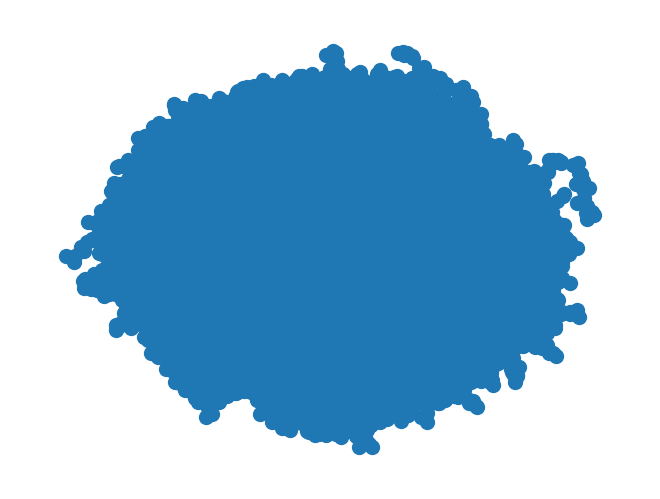

In [ ]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=100, with_labels=False)
plt.show()

In [ ]:
## Heirachical embedding model
embed_model = PoincareModel(edges, size=2)
embed_model.train(epochs=50)
#embed_model.kv.plot()

### HypDRNN

In [ ]:
weights_numpy = embed_model.kv.vectors
weights_tensor = torch.tensor(weights_numpy)
node_to_index = embed_model.kv.key_to_index
vocab_size = len(node_to_index)
embedding_dim = embed_model.kv.vector_size
# Create and freeze the embedding layer
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
embedding_layer.load_state_dict({'weight': weights_tensor})
embedding_layer.weight.requires_grad = False
print(f"Created frozen embedding layer with {vocab_size} nodes.")

Created frozen embedding layer with 89989 nodes.


In [ ]:
class HypDRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, c=1.0):
        super(HypDRNN, self).__init__()

        # Create Curvature and PoincareBall
        self.curvature = Curvature(c)
        self.manifold = PoincareBall(c=self.curvature)

        self.c = c
        self.eps = 1e-15

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Parent-to-Child RNN
        self.parent_input_layer = HLinear(
            embedding_dim,
            hidden_dim,
            manifold=self.manifold
        )
        self.parent_hidden_layer = HLinear(
            hidden_dim,
            hidden_dim,
            manifold=self.manifold
        )

        # Sibling-to-Sibling RNN
        self.sibling_input_layer = HLinear(
            embedding_dim,
            hidden_dim,
            manifold=self.manifold
        )
        self.sibling_hidden_layer = HLinear(
            hidden_dim,
            hidden_dim,
            manifold=self.manifold
        )

        self.combine_layer = HLinear(
            hidden_dim,
            hidden_dim,
            manifold=self.manifold
        )

        print("HypDRNN model initialized in hyperbolic space using hypll.")

    def proj(self, x):
        """Project onto Poincaré ball."""
        sqrt_c = self.c ** 0.5
        max_norm = 1.0 / sqrt_c - self.eps
        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True).clamp(min=self.eps)
        scale = torch.where(x_norm > max_norm, max_norm / x_norm, torch.ones_like(x_norm))
        return x * scale

    def expmap0(self, v):
        """Exponential map at origin."""
        sqrt_c = self.c ** 0.5
        v_norm = torch.norm(v, p=2, dim=-1, keepdim=True).clamp(min=self.eps)
        coef = torch.tanh(sqrt_c * v_norm) / (sqrt_c * v_norm)
        return coef * v

    def mobius_add(self, x, y):
        """Möbius addition."""
        c = self.c
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)

        numerator = (1 + 2 * c * xy + c * y2) * x + (1 - c * x2) * y
        denominator = 1 + 2 * c * xy + c * c * x2 * y2

        return numerator / (denominator + self.eps)

    def parent_rnn_step(self, parent_embedding, hidden_state=None):
        """One RNN step for parent."""
        if hidden_state is None:
            hidden_state = torch.zeros(
                parent_embedding.size(0),
                self.hidden_dim,
                device=parent_embedding.device,
                dtype=parent_embedding.dtype
            )
            hidden_state = self.expmap0(hidden_state)

        # Wrap as ManifoldTensor
        parent_manifold = ManifoldTensor(parent_embedding, manifold=self.manifold)
        hidden_manifold = ManifoldTensor(hidden_state, manifold=self.manifold)

        # Apply layers
        input_contribution = self.parent_input_layer(parent_manifold).tensor
        hidden_contribution = self.parent_hidden_layer(hidden_manifold).tensor

        # Combine
        new_hidden = self.mobius_add(input_contribution, hidden_contribution)
        new_hidden = self.proj(new_hidden)

        return new_hidden

    def sibling_rnn_step(self, sibling_embedding, hidden_state=None):
        """One RNN step for siblings."""
        if hidden_state is None:
            hidden_state = torch.zeros(
                sibling_embedding.size(0),
                self.hidden_dim,
                device=sibling_embedding.device,
                dtype=sibling_embedding.dtype
            )
            hidden_state = self.expmap0(hidden_state)

        # Wrap as ManifoldTensor
        sibling_manifold = ManifoldTensor(sibling_embedding, manifold=self.manifold)
        hidden_manifold = ManifoldTensor(hidden_state, manifold=self.manifold)

        # Apply layers
        input_contribution = self.sibling_input_layer(sibling_manifold).tensor
        hidden_contribution = self.sibling_hidden_layer(hidden_manifold).tensor

        # Combine
        new_hidden = self.mobius_add(input_contribution, hidden_contribution)
        new_hidden = self.proj(new_hidden)

        return new_hidden

    def forward(self, parent_embedding, sibling_embeddings,
                parent_hidden=None, sibling_hidden=None):
        """Forward pass."""
        # Process parent
        hidden_state_p = self.parent_rnn_step(parent_embedding, parent_hidden)

        # Process siblings
        if sibling_embeddings.dim() == 3:
            avg_sibling = sibling_embeddings.mean(dim=1)
        else:
            avg_sibling = sibling_embeddings

        hidden_state_s = self.sibling_rnn_step(avg_sibling, sibling_hidden)

        # Combine
        combined = (hidden_state_p + hidden_state_s) / 2
        combined = self.proj(combined)

        # Final transformation
        combined_manifold = ManifoldTensor(combined, manifold=self.manifold)
        combined_embedding = self.combine_layer(combined_manifold).tensor

        return combined_embedding, hidden_state_p, hidden_state_s

In [ ]:
class DistributionCalculator(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, num_levels, c=1.0):
        super().__init__()

        self.embedding_layer = pretrained_embeddings
        self.embedding_dim = pretrained_embeddings.embedding_dim
        self.hidden_dim = hidden_dim
        self.num_levels = num_levels

        # Create Curvature and PoincareBall
        self.curvature = Curvature(c)
        self.manifold = PoincareBall(c=self.curvature)

        self.c = c
        self.eps = 1e-15

        # Level predictor
        self.level_hyp_layer1 = HLinear(
            self.embedding_dim,
            hidden_dim,
            manifold=self.manifold
        )
        self.level_hyp_layer2 = HLinear(
            hidden_dim,
            hidden_dim,
            manifold=self.manifold
        )

        self.level_euclidean_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_levels),
            nn.Softmax(dim=-1)
        )

        # Path predictor
        self.path_hyp_layer1 = HLinear(
            self.embedding_dim,
            hidden_dim,
            manifold=self.manifold
        )
        self.path_hyp_layer2 = HLinear(
            hidden_dim,
            hidden_dim // 2,
            manifold=self.manifold
        )

        self.path_score_layer = nn.Linear(hidden_dim // 2, 1)

    def logmap0(self, x):
        """Logarithmic map at origin."""
        sqrt_c = self.c ** 0.5
        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True).clamp(min=self.eps)
        coef = torch.atanh(torch.clamp(sqrt_c * x_norm, max=1.0 - self.eps)) / (sqrt_c * x_norm)
        return coef * x

    def forward(self, node_indices):

        # Get embeddings
        embeddings = self.embedding_layer(node_indices)

        # Wrap as ManifoldTensor
        embeddings_manifold = ManifoldTensor(embeddings, manifold=self.manifold)

        # Level Distribution
        level_hidden = self.level_hyp_layer1(embeddings_manifold)
        level_hidden = self.level_hyp_layer2(level_hidden)

        # Unwrap and project to tangent space
        level_hidden_tensor = level_hidden.tensor
        level_tangent = self.logmap0(level_hidden_tensor)

        # Apply Euclidean layers
        level_distribution = self.level_euclidean_layer(level_tangent)

        # === Path Score ===
        path_hidden = self.path_hyp_layer1(embeddings_manifold)
        path_hidden = self.path_hyp_layer2(path_hidden)

        # Unwrap and project to tangent space
        path_hidden_tensor = path_hidden.tensor
        path_tangent = self.logmap0(path_hidden_tensor)

        # Calculate score
        path_score = self.path_score_layer(path_tangent)

        return path_score, level_distribution

In [ ]:
class TopicHierarchyEncoder:
    """
    Main class to tie everything together.
    """
    def __init__(self, embedding_dim, hidden_dim):
        self.tree = None

        # Initialize the core model
        self.hypdrnn_model = HypDRNN(embedding_dim, hidden_dim)

        # Initialize the distribution calculator
        self.distribution_model = DistributionCalculator(hidden_dim)

        self.optimizer = geoopt.optim.RiemannianAdam(
             list(self.hypdrnn_model.parameters()) +
             list(self.distribution_model.parameters()),
             lr=0.01
        )

    def train(self, documents, epochs=10):
        print("\nStarting Model Training ")
        if self.tree is None:
            raise ValueError("Must build tree before training.")

        # Training loop (highly conceptual)
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            # Get embeddings from the tree (these would be parameters)
            parent_emb = torch.randn(self.hypdrnn_model.embedding_dim)
            sibling_embs = torch.randn(3, self.hypdrnn_model.embedding_dim)

            # Forward pass through HypDRNN This would be a complex recursive call over the tree
            effective_embeddings = self.hypdrnn_model(parent_emb, sibling_embs)

            # Forward pass through Distribution Calculator
            topic_distribution = self.distribution_model(effective_embeddings)

            # Calculate Loss
            #    The loss would compare the 'topic_distribution'
            #    with the actual document's topics (e.g., via NLL loss).
            loss = torch.tensor(0.0, requires_grad=True) # Placeholder

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            print(f"Epoch {epoch+1} Complete. Loss: {loss.item()}")

            # Continuous Tree Updating
            self._update_tree_structure()

    def _update_tree_structure(self):
        """
        Placeholder: Based on word proportion (st) and thresholds (add, prune).
        """
        # This logic would check topic cohesion and purity.
        # if (some_metric > threshold.add):
        #    print("Adding new topic node...")
        # if (some_metric < threshold.prune):
        #    print("Pruning stale topic node...")
        pass

    def get_document_topic_distribution(self, doc):

        print(f"\nGetting distribution for: '{doc[:50]}...'")
        # ... inference steps ...
        final_dist = torch.rand(5) # Placeholder
        return final_dist / final_dist.sum()

### HGCN

In [ ]:
!pip install hypll

In [ ]:
import hypll

In [ ]:
#HypLL Imports
from hypll.manifolds.poincare_ball.manifold import PoincareBall
from hypll.tensors import ManifoldTensor
# Corrected import for the linear layer
from hypll.nn.modules.linear import HLinear

In [ ]:
class HyperbolicGCNConv(MessagePassing):
    def __init__(self, in_features, out_features, manifold):
        super(HyperbolicGCNConv, self).__init__(aggr='mean')

        self.manifold = manifold
        self.eps = 1e-15

        # Use regular nn.Linear instead of HypLinear
        self.linear = nn.Linear(in_features, out_features)

    def proj(self, x):
        """Project points onto the Poincaré ball."""
        c_val = self.manifold.c if isinstance(self.manifold.c, (int, float)) else 1.0
        sqrt_c = c_val ** 0.5
        max_norm = 1.0 / sqrt_c - self.eps

        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True).clamp(min=self.eps)
        scale = torch.where(
            x_norm > max_norm,
            max_norm / x_norm,
            torch.ones_like(x_norm)
        )

        return x * scale

    def forward(self, x, edge_index):
        """
        Args:
            x (torch.Tensor): Node features
            edge_index: Edge indices
        """
        x_transformed = self.linear(x)

        # Project onto manifold
        x_transformed = self.proj(x_transformed)

        # Propagate
        out = self.propagate(edge_index, x=x_transformed)

        # Final projection
        return self.proj(out)

    def message(self, x_j):
        return x_j

In [ ]:
class HGNN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, c=1.0):
        super().__init__()

        # Use smaller curvature for better stability
        self.curvature = Curvature(c)
        self.manifold = PoincareBall(c=self.curvature)

        self.c = c
        self.eps = 1e-6  # Increased epsilon for stability

        self.conv1 = HyperbolicGCNConv(in_features, hidden_features, self.manifold)
        self.conv2 = HyperbolicGCNConv(hidden_features, out_features, self.manifold)

        # Better weight initialization
        self._init_weights()

    def _init_weights(self):
        """Initialize weights to keep embeddings near origin."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.1)  # Small gain
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def proj(self, x):
        """Project points onto the Poincaré ball with better stability."""
        sqrt_c = self.c ** 0.5
        # More conservative max norm to stay away from boundary
        max_norm = (1.0 / sqrt_c) * 0.9  # Stay at 90% of boundary

        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True).clamp(min=self.eps)

        scale = torch.clamp(max_norm / x_norm, max=1.0)

        return x * scale

    def expmap0(self, v):
        """Exponential map at origin with numerical stability."""
        sqrt_c = self.c ** 0.5
        v_norm = torch.norm(v, p=2, dim=-1, keepdim=True).clamp(min=self.eps)

        # Clamp input to prevent extreme values
        v_norm_clamped = torch.clamp(v_norm, max=10.0)

        coef = torch.tanh(sqrt_c * v_norm_clamped) / (sqrt_c * v_norm_clamped + self.eps)

        result = coef * v

        # Ensure result is in the ball
        return self.proj(result)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Map Euclidean features to hyperbolic space
        x_hyperbolic = self.expmap0(x)
        x_hyperbolic = self.proj(x_hyperbolic)

        # Pass through conv layers
        x_hyperbolic = self.conv1(x_hyperbolic, edge_index)
        x_hyperbolic = self.conv2(x_hyperbolic, edge_index)

        return x_hyperbolic


### Combine 2 model

In [ ]:
class GTFORMER(nn.Module):
    def __init__(self, in_features, hgnn_hidden, hgnn_out_dim, num_levels, new_c=1.0):
        super().__init__()

        self.hgnn_model = HGNN(
            in_features=in_features,
            hidden_features=hgnn_hidden,
            out_features=hgnn_out_dim,
            c=new_c
        )

        self.manifold = self.hgnn_model.manifold
        self.c = new_c
        self.eps = 1e-6

        self.level_predictor = nn.Sequential(
            nn.Linear(hgnn_out_dim, hgnn_out_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for stability
            nn.Linear(hgnn_out_dim // 2, num_levels)
        )

        self.path_predictor = nn.Linear(hgnn_out_dim, 1)

        # Better initialization
        self._init_weights()

    def _init_weights(self):
        """Initialize weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def logmap0(self, x):
        """Logarithmic map at origin with numerical stability."""
        sqrt_c = self.c ** 0.5
        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True).clamp(min=self.eps)

        # Ensure well within the ball before taking atanh
        # atanh(x) is only defined for |x| < 1
        atanh_arg = sqrt_c * x_norm
        atanh_arg = torch.clamp(atanh_arg, max=1.0 - self.eps)

        # Compute coefficient
        coef = torch.atanh(atanh_arg) / (sqrt_c * x_norm + self.eps)

        result = coef * x

        # Clamp output to prevent extreme values
        result = torch.clamp(result, min=-10.0, max=10.0)

        return result

    def forward(self, data):
        # Get Hyperbolic Embeddings
        hyperbolic_embeddings = self.hgnn_model(data)

        # Map to Tangent Space
        tangent_embeddings = self.logmap0(hyperbolic_embeddings)

        # Calculate Level Logits
        level_logits = self.level_predictor(tangent_embeddings)

        # Calculate Path Logits
        path_logits = self.path_predictor(tangent_embeddings)

        # Calculate Final Topic Log-Probs
        topic_log_probs = F.log_softmax(path_logits.squeeze(), dim=0)

        return topic_log_probs, level_logits, hyperbolic_embeddings

## Setup

#### train

In [ ]:
# Create edge_index
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create Data object with ALL features
data = Data(x=x_features_all, edge_index=edge_index)

print(f"\nCreated graph with computed internal features:")
print(f"  Data: {data}")
print(f"  Non-zero features: {(x_features_all.abs().sum(dim=1) > 0).sum()}")

# Verify
assert data.edge_index.max() < n_total_nodes, "Edge indices out of bounds!"
print("✓ Graph created successfully!")


Created graph with computed internal features:
  Data: Data(x=[89989, 50], edge_index=[2, 89988])
  Non-zero features: 89989
✓ Graph created successfully!


In [ ]:
root_node = n_total_nodes - 1
depths = nx.shortest_path_length(G, source=root_node)
level_labels = torch.zeros(n_total_nodes, dtype=torch.long)

for i in range(n_total_nodes):
    if i in depths:
        level_labels[i] = depths[i]
    else:
        level_labels[i] = 0

max_depth = level_labels.max()
num_levels_in_tree = max_depth.item() + 1

data.level_labels = level_labels

In [ ]:
n_leaves = 89989
indices = torch.randperm(n_leaves)

train_size = int(0.8 * n_leaves)
val_size = int(0.1 * n_leaves)

train_mask = torch.zeros(n_total_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_total_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_total_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:n_leaves]] = True

# Add masks to data
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Node splits:")
print(f"  Train nodes: {train_mask.sum()}")
print(f"  Val nodes: {val_mask.sum()}")
print(f"  Test nodes: {test_mask.sum()}")


Node splits:
  Train nodes: 71991
  Val nodes: 8998
  Test nodes: 9000


In [ ]:
def normalize_features(data):
    """Normalize node features."""
    mean = data.x.mean(dim=0, keepdim=True)
    std = data.x.std(dim=0, keepdim=True) + 1e-6
    data.x = (data.x - mean) / std
    return data

# Apply normalization
data = normalize_features(data)

In [ ]:
model = GTFORMER(
    in_features=20,
    hgnn_hidden=1024,
    hgnn_out_dim=512,
    num_levels=num_levels_in_tree,
    new_c=0.005
)

In [ ]:
import torch.optim as optim
from hypll.tensors import ManifoldParameter

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Loss function
level_loss_fn = nn.CrossEntropyLoss()

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

print(f"Training on device: {device}")

Model has 721716 parameters
Training on device: cuda


In [ ]:
def calculate_graph_structure_loss(embeddings, edge_index, c=1.0, eps=1e-6):
    """Calculate loss with better numerical stability."""
    parents = edge_index[0]
    children = edge_index[1]

    parent_embeds = embeddings[parents]
    child_embeds = embeddings[children]

    # Use simpler distance metric for stability
    diff = parent_embeds - child_embeds
    dist_sq = torch.sum(diff ** 2, dim=-1)
    dist = torch.sqrt(dist_sq + eps)

    return dist.mean()

In [ ]:
NUM_EPOCHS = 4000
best_val_acc = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    topic_log_probs, level_logits, hyperbolic_embeddings = model(data)

    # ONLY use level loss initially
    total_loss = level_loss_fn(
        level_logits[data.train_mask],
        data.level_labels[data.train_mask]
    )

    # Backward pass
    total_loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Validation
    if epoch % 10 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            _, val_level_logits, val_embeddings = model(data)

            val_loss = level_loss_fn(
                val_level_logits[data.val_mask],
                data.level_labels[data.val_mask]
            )

            # Calculate accuracy
            val_preds = val_level_logits[data.val_mask].argmax(dim=1)
            val_acc = (val_preds == data.level_labels[data.val_mask]).float().mean()

            # Training accuracy
            train_preds = level_logits[data.train_mask].argmax(dim=1)
            train_acc = (train_preds == data.level_labels[data.train_mask]).float().mean()

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print(f" New best validation accuracy: {best_val_acc:.4f}")

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
              f"Train Loss: {total_loss.item():.4f} | "
              f"Train Acc: {train_acc.item():.4f} | "
              f"Val Loss: {val_loss.item():.4f} | "
              f"Val Acc: {val_acc.item():.4f}")

print(f"\nTraining completed! Best Val Acc: {best_val_acc:.4f}")

 New best validation accuracy: 0.1004
Epoch [1/2000] | Train Loss: 3.9123 | Train Acc: 0.0180 | Val Loss: 3.8293 | Val Acc: 0.1004
 New best validation accuracy: 0.1261
Epoch [11/2000] | Train Loss: 2.7489 | Train Acc: 0.1222 | Val Loss: 2.7221 | Val Acc: 0.1261
 New best validation accuracy: 0.1400
Epoch [21/2000] | Train Loss: 2.6375 | Train Acc: 0.1354 | Val Loss: 2.6230 | Val Acc: 0.1400
 New best validation accuracy: 0.1437
Epoch [31/2000] | Train Loss: 2.5867 | Train Acc: 0.1421 | Val Loss: 2.5746 | Val Acc: 0.1437
 New best validation accuracy: 0.1446
Epoch [41/2000] | Train Loss: 2.5531 | Train Acc: 0.1502 | Val Loss: 2.5496 | Val Acc: 0.1446
 New best validation accuracy: 0.1530
Epoch [51/2000] | Train Loss: 2.5252 | Train Acc: 0.1530 | Val Loss: 2.5226 | Val Acc: 0.1530
 New best validation accuracy: 0.1606
Epoch [61/2000] | Train Loss: 2.5003 | Train Acc: 0.1566 | Val Loss: 2.4953 | Val Acc: 0.1606
Epoch [71/2000] | Train Loss: 2.4760 | Train Acc: 0.1613 | Val Loss: 2.4781 |

## comparison score dataframe

In [9]:
import pandas as pd

In [13]:
compare_df = pd.DataFrame({'model':['lda','nmf','bert','top2Vec'],
                           'type':['classic','classic','modern','modern'],
                           'num_k':[best_min_size_lda,best_min_size_nmf,best_min_size,num_topics_t2v],
                           'coherence':[best_score_lda,best_score_nmf,best_score,coherence_score]})

In [14]:
compare_df

model     type  num_k  coherence
0      lda  classic      5    0.63064
1      nmf  classic     20    0.71422
2     bert   modern     20    0.72753
3  top2Vec   modern    204    0.37716